# Earth Observation Temporal Stack
The class eoTempStack reads the resulting products of the pre-processed Sentinel-1, Sentinel-2 and Landsat (7/8) images. The pre-processing script results in a defined directory structure with is hard coded in the class methods. The class has the necessary methods to calculate two vegetation indices from the available optical images.



In [1]:
import sys
sys.path.append('../b_Temporal_Stack')
# Import the eotempstack package
import eotempstack as eots

## EO_Temp_Stack class

This class functions as a wrapper for methods to read and stack multi-temporal earth observation images into multi-temporal da

### Sentinel-2

First we try to read the temporal stack of the region of Casanare. This extends to more than one Sentinel-2 tile, so it is necesary to mosaic the images. In this step, all optical bands are mosaiced, NDVI and LSWI indices are calculated and written as tif images. (this might take a while! processing 4 months)

In [5]:
import os

s2 = eots.S2TempStack(os.environ['WIN_SVR_DATA']+'Casanare/pre/',
                      os.environ['WIN_SVR_DATA']+'Casanare/stack/')


S2 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Casanare/pre/
Mosaicing swir2 band for 2018-01-16
swir2 band mosaic for 2018-01-16 failed, will be excluded from S2 eotempstack
Mosaicing qa_cloud band for 2018-01-16
qa_cloud band mosaic for 2018-01-16 failed, will be excluded from S2 eotempstack
Mosaicing qa_class band for 2018-01-16
qa_class band mosaic for 2018-01-16 failed, will be excluded from S2 eotempstack


/home/azalazar/anaconda3/envs/models3/lib/python3.6/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


In [29]:
# The EOTempStack class operates over a dictionary to map the location of the earth observation images
s2_loc = s2.getBandsLoc('NDVI')[0:3]
# and their temporal information
s2_time = s2.getTempData('NDVI')[0:3]
# We can they are stored with the same indices
for idx, loc in enumerate(s2_loc):
    print('An NDVI image file corresponding to {} is located at: {} \n '.format(s2_time[idx], loc))
# ... in a list
type(loc_sub)

An NDVI image file corresponding to 2018-01-01 is located at: /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Casanare/pre/S2_NDVI_20180101_.tif 
 
An NDVI image file corresponding to 2018-01-06 is located at: /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Casanare/pre/S2_NDVI_20180106_.tif 
 
An NDVI image file corresponding to 2018-01-11 is located at: /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Casanare/pre/S2_NDVI_20180111_.tif 
 


list

### Sentinel-1

In the case of Sentinel-1, the class does not implement mosaicing, as pre-processing considers slice assembly. In this case, data corresponding to multiple dates is stored within one BEAM-DIMAP file, with all the bands in the *.data directory, with acquisition date of each image in the format DDMMMMYYYY

In [19]:
s1 = eots.S1TempStack(os.environ['WIN_SVR_DATA']+'Casanare/pre/ASCENDING',
                      os.environ['WIN_SVR_DATA']+'Casanare/stack/',
                      orbit='ASCENDING')

S1 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Casanare/pre/ASCENDING/


In [27]:
s1_time = s1.getTempData('VV')[:3]
s1_loc = s1.getBandsLoc('VV')[:3]
for idx, loc in enumerate(s1_loc):
    print('A Sentinel-1 VV image file corresponding to {} is located at: {} \n '.format(s1_time[idx], loc))

A Sentinel-1 VV image file corresponding to 2018-04-10 is located at: /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Casanare/pre/ASCENDING/S1_SPF_ASCENDING_VV_P20180519_0.data/Sigma0_VV_mst_10Apr2018_S_db.img 
 
A Sentinel-1 VV image file corresponding to 2018-04-22 is located at: /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Casanare/pre/ASCENDING/S1_SPF_ASCENDING_VV_P20180519_0.data/Sigma0_VV_slv2_22Apr2018_S_db.img 
 
A Sentinel-1 VV image file corresponding to 2018-04-05 is located at: /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Casanare/pre/ASCENDING/S1_SPF_ASCENDING_VV_P20180519_0.data/Sigma0_VV_slv4_05Apr2018_S_db.img 
 


## RegionStack class

The region stack class functions as a layer on top of *EO_Temp_Stack* class, which also handles the directory structure for image files reading and stack writing.

This calls calls the *eotempstack.eoTempStack.createXDataset* method which reads all the bands mapped in the *eoTempStack* object location dictionary, and builds an *xarray.Dataset* object, using rasterio to read the image files.

The method also builds a quality mask for optical datasets based on the quality thresholds specified in the cloud quality limit dictionary, stored as an attribute of each *eotempstack.opticalTempStack* subclass.

### Paralellized processing

Using the open_rasterio method, the xarray package uses dask to read the images in chunks as dask arrays, avoiding loading all the data into memory at once.

In [2]:
from distributed import Client

client = Client(n_workers=6)

client

Client Scheduler: tcp://127.0.0.1:46552 Dashboard: http://127.0.0.1:59295/status,Cluster Workers: 6 Cores: 24 Memory: 33.55 GB


In [5]:
import regionstack

saldana = regionstack.regionStack('Saldana', attrs=['S2','S1_ASCENDING'])

S2 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana/pre/
Reading 3 S2 stack files
S1 object initialized from /mnt/workspace_cluster_6/TRANSVERSAL_PROJECTS/MADR/COMPONENTE_2/Imagenes_Satelitales/Temp/asalazar_tests/data/Saldana/pre/
Reading 11 S1 stack files


## xarray.Dataset structure
The regionstack class loads the available time series as xr.Dataset objects. These are read as dask arrays, avoiding loading all the data into memory. All the variables consist are stored as arrays which share the sames dimensions and coordinates. The x and y index represent pixel each pixel location in a spatial grid. More information can be found in [this link](http://xarray.pydata.org/en/stable/auto_gallery/plot_rasterio.html#sphx-glr-auto-gallery-plot-rasterio-py).

Spatial coordinates are taken from the projection of the Sentinel-2 image files. In this case they correspong to WGS84 18N (epsg:32618).

In [7]:
saldana.S2

<xarray.Dataset>
Dimensions:  (time: 8, x: 2979, y: 3631)
Coordinates:
  * y        (y) float64 4.485e+05 4.484e+05 4.484e+05 4.484e+05 4.484e+05 ...
  * x        (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
  * time     (time) datetime64[ns] 2015-12-11 2015-12-21 2015-12-31 ...
    mask     (time, y, x) int8 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
Data variables:
    blue     (time, y, x) uint16 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    green    (time, y, x) uint16 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    red      (time, y, x) uint16 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    nir      (time, y, x) uint16 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    swir1    (time, y, x) uint16 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    swir2    (time, y, x) uint16 dask.array<shape=(8, 3631, 2979), chunksize=(8, 1000, 1000)>
    NDVI     (time, y, x) f

To get the data to from a variable corresponding to a specific time or area of interest within the dataset, we can make use of xarray's [index and selection](http://xarray.pydata.org/en/stable/indexing.html) methods, which allow indexin by coordinates.

In [30]:
spatio_temp_subset = saldana.S2.sel(time='2015-12-21', y=slice(442100, 441175), x=slice(488900, 490100))
spatio_temp_subset

<xarray.Dataset>
Dimensions:  (x: 120, y: 93)
Coordinates:
  * y        (y) float64 4.421e+05 4.421e+05 4.421e+05 4.421e+05 4.421e+05 ...
  * x        (x) float64 4.889e+05 4.889e+05 4.889e+05 4.889e+05 4.889e+05 ...
    time     datetime64[ns] 2015-12-21
    mask     (y, x) int8 dask.array<shape=(93, 120), chunksize=(93, 120)>
Data variables:
    blue     (y, x) uint16 dask.array<shape=(93, 120), chunksize=(93, 120)>
    green    (y, x) uint16 dask.array<shape=(93, 120), chunksize=(93, 120)>
    red      (y, x) uint16 dask.array<shape=(93, 120), chunksize=(93, 120)>
    nir      (y, x) uint16 dask.array<shape=(93, 120), chunksize=(93, 120)>
    swir1    (y, x) uint16 dask.array<shape=(93, 120), chunksize=(93, 120)>
    swir2    (y, x) uint16 dask.array<shape=(93, 120), chunksize=(93, 120)>
    NDVI     (y, x) float32 dask.array<shape=(93, 120), chunksize=(93, 120)>
    LSWI     (y, x) float32 dask.array<shape=(93, 120), chunksize=(93, 120)>

We can also use the plot method on the DataArray objects to visualize the data. Plotting methods are based in the matplotlib library, so additional arguments can be passed. 

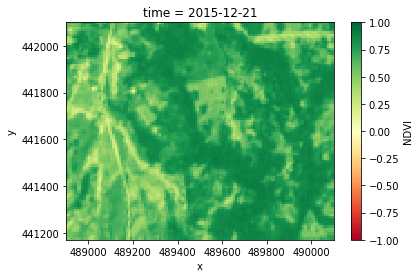

In [32]:
spatio_temp_subset.NDVI.plot(cmap='RdYlGn', vmin=-1, vmax=1)

## Quality mask
Each optical dataset is built with a pixel quality mask, according to the parameters indicated in the EOTempStack subclasses. Using this quality mask we can calculate percentage of quality pixels for each optical image.

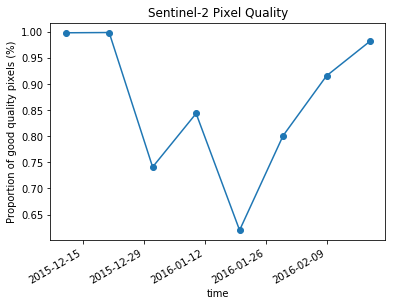

In [43]:
from matplotlib import pyplot as plt
# Calculate and plot percentage of quality pixels
saldana.S2.mask.mean(['x', 'y']).sortby('time').plot.line(x='time', marker='o')
plt.title('Sentinel-2 Pixel Quality')
plt.ylabel('Proportion of good quality pixels (%)')
plt.show()

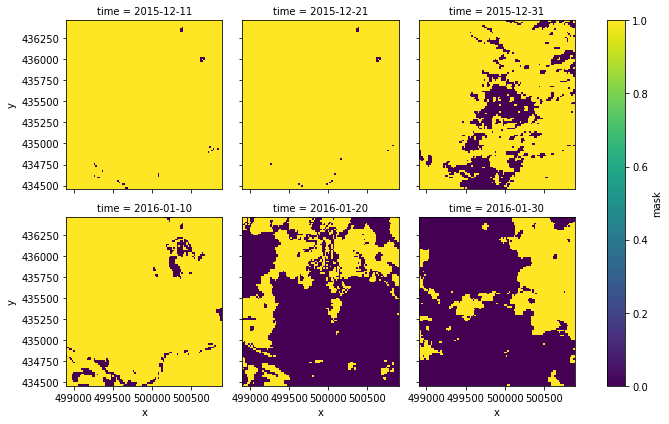

In [46]:
# We can also visualize the time series of the quality mask.
saldana.S2.mask.isel(time=slice(0,6), y=slice(1200,1400), x=slice(1000,1200)).plot(col='time', col_wrap=3)

## Plotting
Plotting time series of a defined pixel, we can specify the coordinate to retrieve the corresponding data.

<xarray.Dataset>
Dimensions:  (time: 8)
Coordinates:
    y        float64 4.355e+05
    x        float64 4.995e+05
  * time     (time) datetime64[ns] 2015-12-11 2015-12-21 2015-12-31 ...
    mask     (time) int8 dask.array<shape=(8,), chunksize=(8,)>
Data variables:
    blue     (time) uint16 dask.array<shape=(8,), chunksize=(8,)>
    green    (time) uint16 dask.array<shape=(8,), chunksize=(8,)>
    red      (time) uint16 dask.array<shape=(8,), chunksize=(8,)>
    nir      (time) uint16 dask.array<shape=(8,), chunksize=(8,)>
    swir1    (time) uint16 dask.array<shape=(8,), chunksize=(8,)>
    swir2    (time) uint16 dask.array<shape=(8,), chunksize=(8,)>
    NDVI     (time) float32 dask.array<shape=(8,), chunksize=(8,)>
    LSWI     (time) float32 dask.array<shape=(8,), chunksize=(8,)>


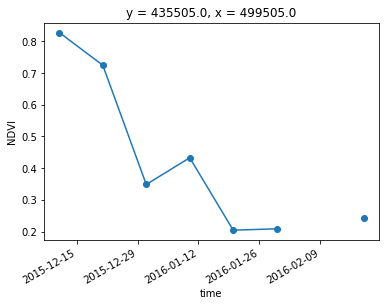

In [57]:
pixel = saldana.S2.sel(x=499505, y=435505)
ndvi_pixel.NDVI.sortby('time').plot(x='time', marker='o')
print(pixel)

Masking the time series using the quality mask

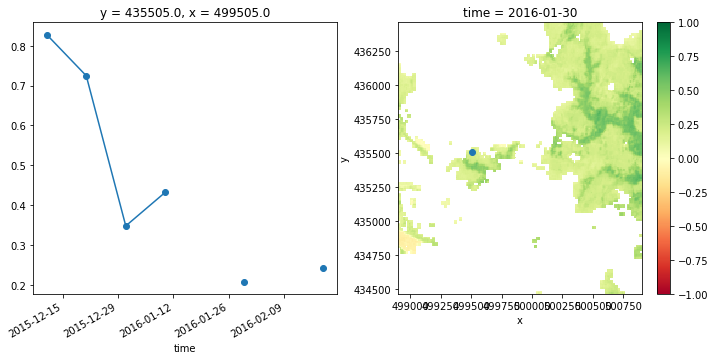

In [84]:
# We can also make use of the mask to keep only quality pixels
ndvi_subset = saldana.S2.NDVI.isel(y=slice(1200,1400), x=slice(1000,1200))
mask_subset = saldana.S2.mask.isel(y=slice(1200,1400), x=slice(1000,1200))

x = 499505
y = 435505
time = '2016-01-30'

fig, ax = plt.subplots(1,2,figsize=(12,5))

# Plot only valid measurements for the same pixel
ndvi_subset.where(mask_subset).sel(x=499505, y=435505).plot(ax=ax[0],marker='o')

# Mask only valid pixels
ndvi_subset.sel(time=time).where(mask_subset.sel(time=time)).plot(cmap='RdYlGn',
                                                                                  vmin=-1,
                                                                                  vmax=1,
                                                                                  ax=ax[1])
ax[1].scatter(x=x, y=y)

## Radar data
Plot VV values for the same pixel

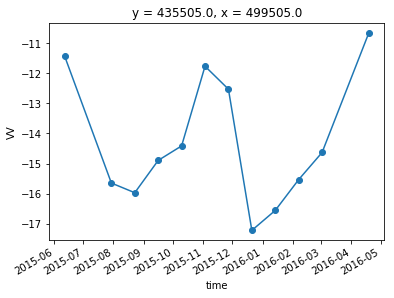

In [81]:
saldana.S1_ASCENDING.VV.sel(x=499505, y=435505).sortby('time').plot.line(x='time', marker='o')

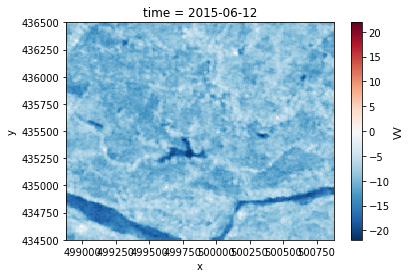

In [86]:
saldana.S1_ASCENDING.VV.isel(y=slice(1200,1400), x=slice(1000,1200),time=0).plot()

## xarray custom methods

Use xarray register accessors to perform user defined methods to extend the functionality of xarray objects. Here, we define a method in the xarray.Dataset accesor to plot the rgb image of an optical dataset.

In [49]:
from xr_eotemp import *

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


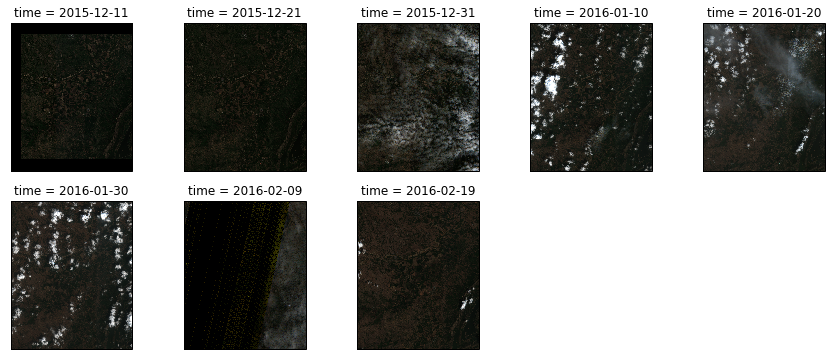

In [51]:
saldana.S2.eotemp.plot_RGB()  # calls the EOTempArray.plot_RGB method